In [40]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.2f}".format

def unpack_data():

    data_dir = '../data/drydays'

# Find all .tar.gz files in the data directory
    tar_files = glob.glob(os.path.join(data_dir, '*.zip'))

# Unpack and remove each .tar.gz file
    for tar_file in tar_files:
        os.system(f'tar -xf {tar_file} -C {data_dir}')
        os.remove(tar_file)

In [3]:
import cdsapi
    
c = cdsapi.Client()

c.retrieve(
    'sis-extreme-indices-cmip6',
    {
        'version': '2_0',
        'format': 'zip',
        'variable': 'consecutive_dry_days',
        'product_type': 'base_independent',
        'temporal_aggregation': 'yearly',
        'period': '1850-2016',
        'experiment': 'historical',
        'ensemble_member': 'r1i1p1f1',
        'model': 'fgoals_g3',
    },
    f'../data/drydays/download.zip')
    
unpack_data()

2023-06-09 16:04:05,065 INFO Welcome to the CDS
2023-06-09 16:04:05,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-extreme-indices-cmip6
2023-06-09 16:04:05,233 INFO Request is completed
2023-06-09 16:04:05,235 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/dataset-sis-extreme-indices-cmip6-2babf0b6-d7d4-45a5-8af1-085b15b1210a.zip to ../data/drydays/download.zip (2.6M)
2023-06-09 16:04:06,018 INFO Download rate 3.4M/s   


In [30]:
import xarray as xr

year_min = 2001
lat_low = 30
lat_high = 55
lon_low = 347
lon_high = 53

data_dir = '../data/drydays'
file_name = os.listdir(data_dir)[0]
file_path = os.path.join(data_dir, file_name)
df = xr.open_dataset(file_path, engine='netcdf4').to_dataframe()
df.reset_index(inplace=True)
df = df[(df['lat']>=lat_low) & (df['lat']<=lat_high) & ((df['lon']<=lon_high) | (df['lon']>=lon_low))]
df['time'] = pd.to_datetime(df['time'].astype("string"), format='%Y-%m-%d %H:%M:%S')
df['year'] = df['time'].dt.year
df = df[(df['year']>=year_min)]
df['dry_days'] = df['cddETCCDI'] / pd.to_timedelta(1, unit='D')
df.drop(['bnds','time','lon_bnds','lat_bnds','height','time_bnds','cddETCCDI'], inplace=True, axis=1)
df['lon'] = df['lon'].map(lambda x: x-360 if x >= lon_low else x).round(decimals=1)
df['lat'] = df['lat'].round(decimals=1)
df = df.drop_duplicates()
df

,lon,lat,year,dry_days
9336,0.0,31.4,2001,79.0
9337,0.0,31.4,2002,130.0
9338,0.0,31.4,2003,94.0
9339,0.0,31.4,2004,88.0
9340,0.0,31.4,2005,50.0
...,...,...,...,...
4794064,-2.0,53.7,2012,25.0
4794065,-2.0,53.7,2013,15.0
4794066,-2.0,53.7,2014,10.0
4794067,-2.0,53.7,2015,16.0


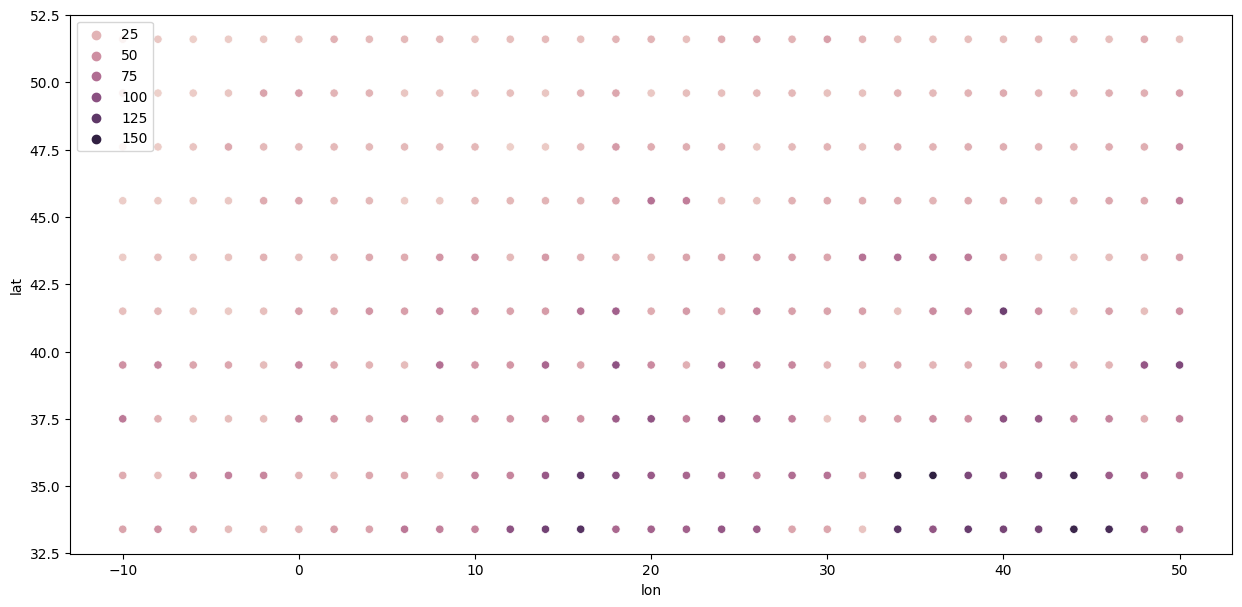

In [5]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df[df['year']==2011], x='lon', y='lat', hue = 'dry_days')
plt.legend(loc='upper left');

In [43]:
import geopandas
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata

def interpolation(dataframe,year):
    df = dataframe[dataframe['year']==year]
    gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326",
    )
    geo_grid_linear = make_geocube(
        gdf,
        measurements=["dry_days"],
        resolution=(-0.25, 0.25),
        rasterize_function=partial(rasterize_points_griddata, method="linear"),
        interpolate_na_method="nearest",
    )
    return geo_grid_linear

#geo_grid_linear.dry_days.plot.imshow()

In [46]:
year_min = 2001
year_max = 2016
lat_low = 33
lat_high = 52
lon_low = -10
lon_high = 50

df_final = pd.DataFrame(columns=['lat', 'lon', 'year', 'dry_days'])

for year in range(year_min,year_max+1):
    grid = interpolation(df,year).to_dataframe()
    grid['year'] = year
    grid.reset_index(inplace=True)
    grid['y'] = grid['y'] + 0.125
    grid['x'] = grid['x'] + 0.125
    grid = grid.rename(columns={'x':'lon','y':'lat'})
    grid = grid[(grid['lat']>=lat_low) & (grid['lat']<=lat_high) & (grid['lon']<=lon_high) & (grid['lon']>=lon_low)]
    grid = grid.reset_index()
    grid = grid.drop(['index','spatial_ref'], axis=1)
    df_final = df_final.append(grid)
    
df_final

/var/folders/hz/grztnvrj73x44n1hcwn7gthh0000gn/T/ipykernel_8434/1288731321.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(grid)
/var/folders/hz/grztnvrj73x44n1hcwn7gthh0000gn/T/ipykernel_8434/1288731321.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(grid)
/var/folders/hz/grztnvrj73x44n1hcwn7gthh0000gn/T/ipykernel_8434/1288731321.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(grid)
/var/folders/hz/grztnvrj73x44n1hcwn7gthh0000gn/T/ipykernel_8434/1288731321.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(grid)


,lat,lon,year,dry_days
0,52.00,-10.00,2001,18.54
1,52.00,-9.75,2001,18.73
2,52.00,-9.50,2001,18.93
3,52.00,-9.25,2001,19.05
4,52.00,-9.00,2001,19.18
...,...,...,...,...
18552,33.00,49.00,2016,79.09
18553,33.00,49.25,2016,73.59
18554,33.00,49.50,2016,68.09
18555,33.00,49.75,2016,64.01


In [51]:
(20*4-3)*(60*4+1)

18557

In [48]:
df_final.to_csv('../data/drydays.csv')